# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


#### initialize libraries

In [1]:
import sys;sys.path.append('../adcirc_swan')
import adcirc as adc;import regional as reg
from arctic import *;import glob;import os;
import utils as ut;import pathlib as pl
import sys;sys.path.append('../../Kalpana/')
from kalpana.export import *
from scipy.io import loadmat 
import matplotlib.pyplot as plt;import xarray as xr
import netCDF4 as nc4;import pandas as pd
import requests;import json;import matplotlib as mpl
import numpy as np;from datetime import datetime
import matplotlib.tri as tri;
import datetime as dt;from cartopy import config
import cartopy as cart;import cartopy.crs as ccrs
import cartopy.io.img_tiles as cart_img
import scipy.interpolate;import cmocean
import geopandas as gpd; import wavespectra as wspec
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
import imageio

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


#### Initialize paths
---

In [2]:
root = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/sea_ice')
ncfile = nc4.Dataset(root / 'nsidc' / 'outputs' / 'swan_HS.63.nc')

#### Load in netcdf file. define lat/lons and time
---

In [3]:
start = '20191001 00:00'
dt2 = pd.date_range(start=start,periods=int(len(ncfile.variables['swan_HS'][:,0])),freq='60min')
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]

In [4]:
# load in the observation data
opath = pl.Path('/Users/tmiesse/work/FHRL/arctic/obs_data/uw_data/wavedata_converted')
files = list((opath ).glob('*.nc'))
file = xr.open_dataset(files[0], engine='netcdf4')
files.sort()

In [5]:
# Find the nodes closest to the initial location of the buoys
nodes = {'S1P1':0,'S1P2':0,'S1P3':0,'S1P4':0,'S1A1':0,'S2A1':0,'S2P1':0,'S2P3':0,'S3P1':0,'S3A1':0}
for j in files:
    step = 0.15
    file = xr.open_dataset(j, engine='netcdf4')
    poly = Polygon([(file['lon'][0]-step,file['lat'][0]-step),(file['lon'][0]-step,file['lat'][0]+step),
                   (file['lon'][0]+step,file['lat'][0]+step),(file['lon'][0]+step,file['lat'][0]-step)])
    node= np.where(shapely.vectorized.contains(poly, x, y)==True)[0]
    while len(node)>1:
        step-=0.00025
        poly = Polygon([(file['lon'][0]-step,file['lat'][0]-step),(file['lon'][0]-step,file['lat'][0]+step),
                   (file['lon'][0]+step,file['lat'][0]+step),(file['lon'][0]+step,file['lat'][0]-step)])
        node = np.where(shapely.vectorized.contains(poly, x, y)==True)[0]
    nodes[j.name.split('.')[0]] = node
    

In [6]:
j = files[0]

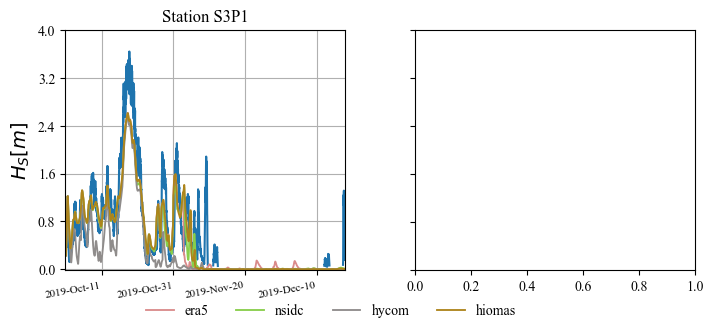

In [6]:
plt.rcParams["font.family"] = "Times New Roman"
colors = ['#1e74ae','#da8b8b','#88ce4b','#8f8c8b',
          '#ad841c','#994F00','#40B0A6','#D41159']

width =1.33
directories = ['era5','nsidc','hycom','hiomas']

fig = plt.figure(figsize=(7,3))
#ax = [plt.axes([0,0.55,0.48,.4]),plt.axes([0.51,0.55,0.48,.4]),
#      plt.axes([0.,0.,.48,.4]),plt.axes([0.51,0.,.48,.4])]
ax = [plt.axes([0,0.,0.4,.8]),plt.axes([0.5,0.,0.4,.8])]#,plt.axes([0.66,0.,0.3,.8])]
r2,c2=0,0
# field data
count = 0
for j in files:
    if ('S3' in j.name.split('.')[0]) and ('A' not in j.name.split('.')[0]):
        file = xr.open_dataset(j, engine='netcdf4')
        dt = pd.to_datetime(file['time']-719529, unit='D')
        hso = file['sigwaveheight'][:]
        ax[count].plot(dt,hso,color=colors[0],linewidth=1.5)
        c2=1
        node = [n for n in nodes.keys() if j.name.split('.')[0]==n]
        for d in directories:
            ncfile = nc4.Dataset(root / d / 'outputs' /'swan_HS.63.nc')
            start = '20191001 00:00'
            dt2 = pd.date_range(start=start,periods=int(len(ncfile['swan_HS'][:,0])),freq='60min')
            # model data 
            ax[count].plot(dt2,ncfile['swan_HS'][:,nodes[node[0]]],label=f"{d}",color=colors[c2],linewidth=width)
            c2+=1
        idt = np.where((start<dt)&(dt<pd.to_datetime('20191225'))&(~np.isnan(hso)))[0]
        ax[count].set_xlim([dt[idt[0]]-pd.Timedelta(hours=6),dt[idt[-1]]+pd.Timedelta(hours=6)])
        ax[count].set_ylim([-0.01,4])
        ax[count].tick_params(axis='x', labelsize=8),ax[count].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d'))
        for label in ax[count].get_xticklabels(which='major'):
            label.set(rotation=10, horizontalalignment='right')
        ax[count].xaxis.set_major_locator(plt.MaxNLocator(5)),ax[count].yaxis.set_major_locator(plt.MaxNLocator(6))
        ax[count].set_title(f"Station {j.name.split('.')[0]}",fontsize=12)
        ax[count].grid(True)
        count+=1
# plot limits


for i in [1]:#,3,5,6,7,9]:
    ax[i].set_yticklabels(['','','','','',''])#, ax2.set_xticks([])

ax[0].set_ylabel(r'$ H_{S} [m]$',fontsize=14)
#ax[2].set_ylabel(r'$ H_{S} [m]$',fontsize=14)
#ax[8].set_ylabel(r'$ H_{S} [m]$',fontsize=14)

#fig.delaxes(ax[5])
#fig.delaxes(ax[8])
ax[0].legend(loc='lower center', bbox_to_anchor=(.95, -.25),ncol=4,frameon=False,fontsize=10)

plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/hs_s2.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1),
plt.show()

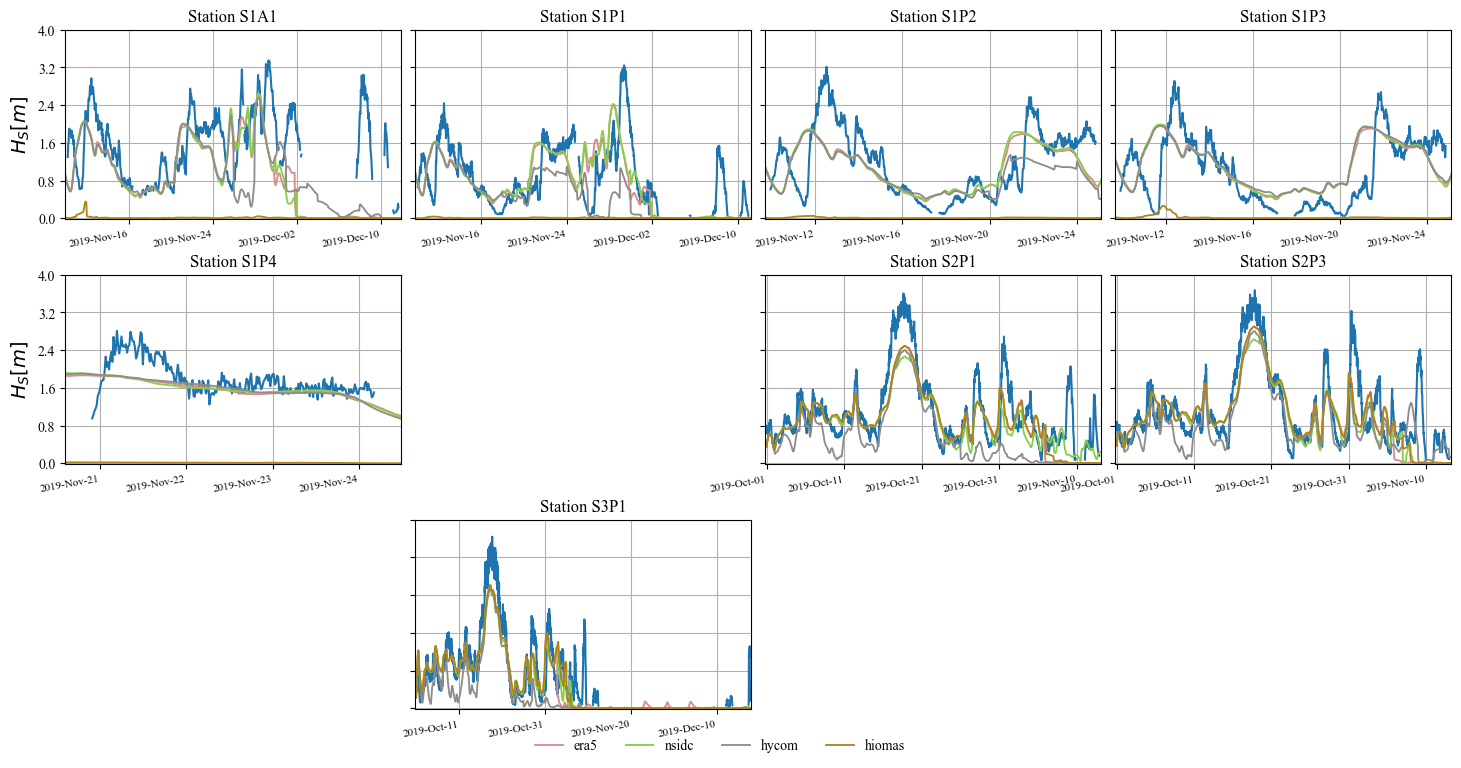

In [7]:
plt.rcParams["font.family"] = "Times New Roman"
colors = ['#1e74ae','#da8b8b','#88ce4b','#8f8c8b',
          '#ad841c','#994F00','#40B0A6','#D41159']

width =1.33
directories = ['era5','nsidc','hycom','hiomas']

fig = plt.figure(figsize=(14,7))
ax = [plt.axes([0,0.7,0.24,.27]),plt.axes([0.25,0.7,0.24,.27]),plt.axes([0.5,0.7,.24,.27]),plt.axes([0.75,0.7,.24,.27]),
     plt.axes([0,0.35,.24,.27]),plt.axes([0.25,0.35,.24,.27]),plt.axes([0.5,0.35,.24,.27]),plt.axes([0.75,0.35,.24,.27]),
     plt.axes([0,0,.24,.27]),plt.axes([0.25,0,.24,.27])]
r2,c2=0,0
# field data
count = 0
for j in files:
    # observation data
    file = xr.open_dataset(j, engine='netcdf4')
    dt = pd.to_datetime(file['time']-719529, unit='D')
    hso = file['sigwaveheight'][:]
    ax[count].plot(dt,hso,color=colors[0],linewidth=1.5)
    c2=1
    node = [n for n in nodes.keys() if j.name.split('.')[0]==n]
    for d in directories:
        ncfile = nc4.Dataset(root / d / 'outputs' /'swan_HS.63.nc')
        start = '20191001 00:00'
        dt2 = pd.date_range(start=start,periods=int(len(ncfile['swan_HS'][:,0])),freq='60min')
        # model data 
        ax[count].plot(dt2,ncfile['swan_HS'][:,nodes[node[0]]],label=f"{d}",color=colors[c2],linewidth=width)
        c2+=1
    idt = np.where((start<dt)&(dt<pd.to_datetime('20191225'))&(~np.isnan(hso)))[0]
    ax[count].set_xlim([dt[idt[0]]-pd.Timedelta(hours=6),dt[idt[-1]]+pd.Timedelta(hours=6)])
    ax[count].set_ylim([-0.01,4])
    ax[count].tick_params(axis='x', labelsize=8),ax[count].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d'))
    for label in ax[count].get_xticklabels(which='major'):
        label.set(rotation=10, horizontalalignment='right')
    ax[count].xaxis.set_major_locator(plt.MaxNLocator(5)),ax[count].yaxis.set_major_locator(plt.MaxNLocator(6))
    ax[count].set_title(f"Station {j.name.split('.')[0]}",fontsize=12)
    ax[count].grid(True)
    count+=1
# plot limits


for i in [1,2,3,5,6,7,9]:
    ax[i].set_yticklabels(['','','','','',''])#, ax2.set_xticks([])

ax[0].set_ylabel(r'$ H_{S} [m]$',fontsize=14)
ax[4].set_ylabel(r'$ H_{S} [m]$',fontsize=14)
ax[8].set_ylabel(r'$ H_{S} [m]$',fontsize=14)

fig.delaxes(ax[5])
fig.delaxes(ax[8])
ax[0].legend(loc='lower center', bbox_to_anchor=(1.95, -2.89),ncol=4,frameon=False,fontsize=10)

plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/hs_validation_v2.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1),
plt.show()

#### Difference plot

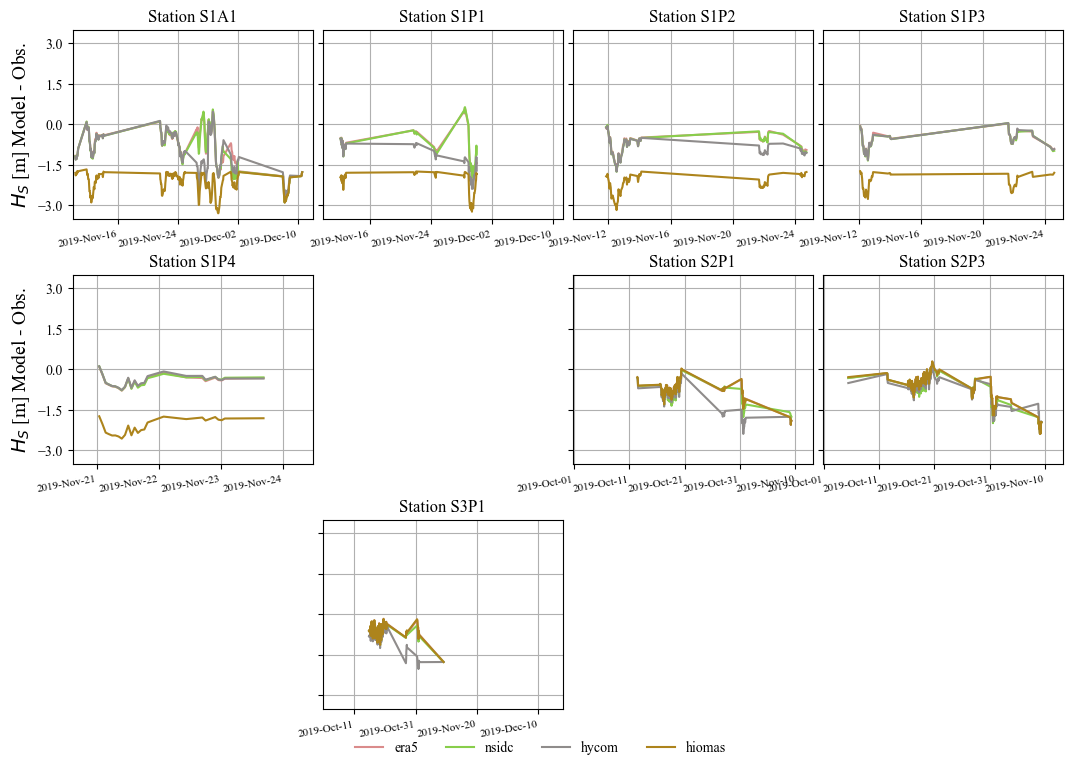

In [6]:
plt.rcParams["font.family"] = "Times New Roman"
colors = ['#1e74ae','#da8b8b','#88ce4b','#8f8c8b',
          '#ad841c','#994F00','#40B0A6','#D41159']
width =1.33
directories = ['era5','nsidc','hycom','hiomas']
peakstart,peakend = pd.to_datetime('20191115'),pd.to_datetime('20191125')
fig = plt.figure(figsize=(10,7))
ax = [plt.axes([0,0.7,0.24,.27]),plt.axes([0.25,0.7,0.24,.27]),plt.axes([0.5,0.7,.24,.27]),plt.axes([0.75,0.7,.24,.27]),
     plt.axes([0,0.35,.24,.27]),plt.axes([0.25,0.35,.24,.27]),plt.axes([0.5,0.35,.24,.27]),plt.axes([0.75,0.35,.24,.27]),
     plt.axes([0,0,.24,.27]),plt.axes([0.25,0,.24,.27])]
r2,c2=0,0
# field data
count = 0
for j in files:
    # observation data
    file = xr.open_dataset(j, engine='netcdf4')
    dt = pd.to_datetime(file['time']-719529, unit='D')
    c2=1
    node = [n for n in nodes.keys() if j.name.split('.')[0]==n]
    for d in directories[:]:
        ncfile = nc4.Dataset(root / d / 'outputs' /'swan_HS.63.nc')
        start = '20191001 00:00'
        dt2 = pd.date_range(start=start,periods=int(len(ncfile['swan_HS'][:,0])),freq='60min')
        dt3 = pd.date_range(start=start,end=dt2[-1],freq='60min')
        hso = np.interp(dt3,dt,file['sigwaveheight'])
        hsm = np.interp(dt3,dt2,ncfile['swan_HS'][:,nodes[node[0]][0]])
        hsm[np.isnan(hso)]=np.nan
        idp = np.where(hso>1.75)[0]
        
        # model data 
        ax[count].plot(dt3[idp],hsm[idp]-hso[idp],label=f"{d}",c=colors[c2])
        c2+=1
        
    idt = np.where((start<dt)&(dt<pd.to_datetime('20191231'))&(~np.isnan(file['sigwaveheight'])))[0]
    ax[count].set_xlim([dt[idt[0]]-pd.Timedelta(hours=6),dt[idt[-1]]+pd.Timedelta(hours=6)])
    ax[count].set_ylim([-3.5,3.5])
    ax[count].tick_params(axis='x', labelsize=8),ax[count].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d'))
    for label in ax[count].get_xticklabels(which='major'):
        label.set(rotation=10, horizontalalignment='right')
    ax[count].xaxis.set_major_locator(plt.MaxNLocator(5)),ax[count].yaxis.set_major_locator(plt.MaxNLocator(6))
    ax[count].set_title(f"Station {j.name.split('.')[0]}",fontsize=12)
    ax[count].grid(True)
    count+=1
# plot limits


for i in [1,2,3,5,6,7,9]:
    ax[i].set_yticklabels(['','','','','',''])#, ax2.set_xticks([])
fig.delaxes(ax[5])
fig.delaxes(ax[8])
ax[0].set_ylabel(r'$ H_{S}$ [m] Model - Obs.',fontsize=14)
ax[4].set_ylabel(r'$ H_{S}$ [m] Model - Obs.',fontsize=14)
ax[8].set_ylabel(r'$ H_{S}$ [m] Model - Obs.',fontsize=14)
#fig.delaxes(ax[3][2])
ax[0].legend(loc='lower center', bbox_to_anchor=(1.95, -2.90),ncol=4,frameon=False,fontsize=10)

plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/hs_difference_v2.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1),
plt.show()

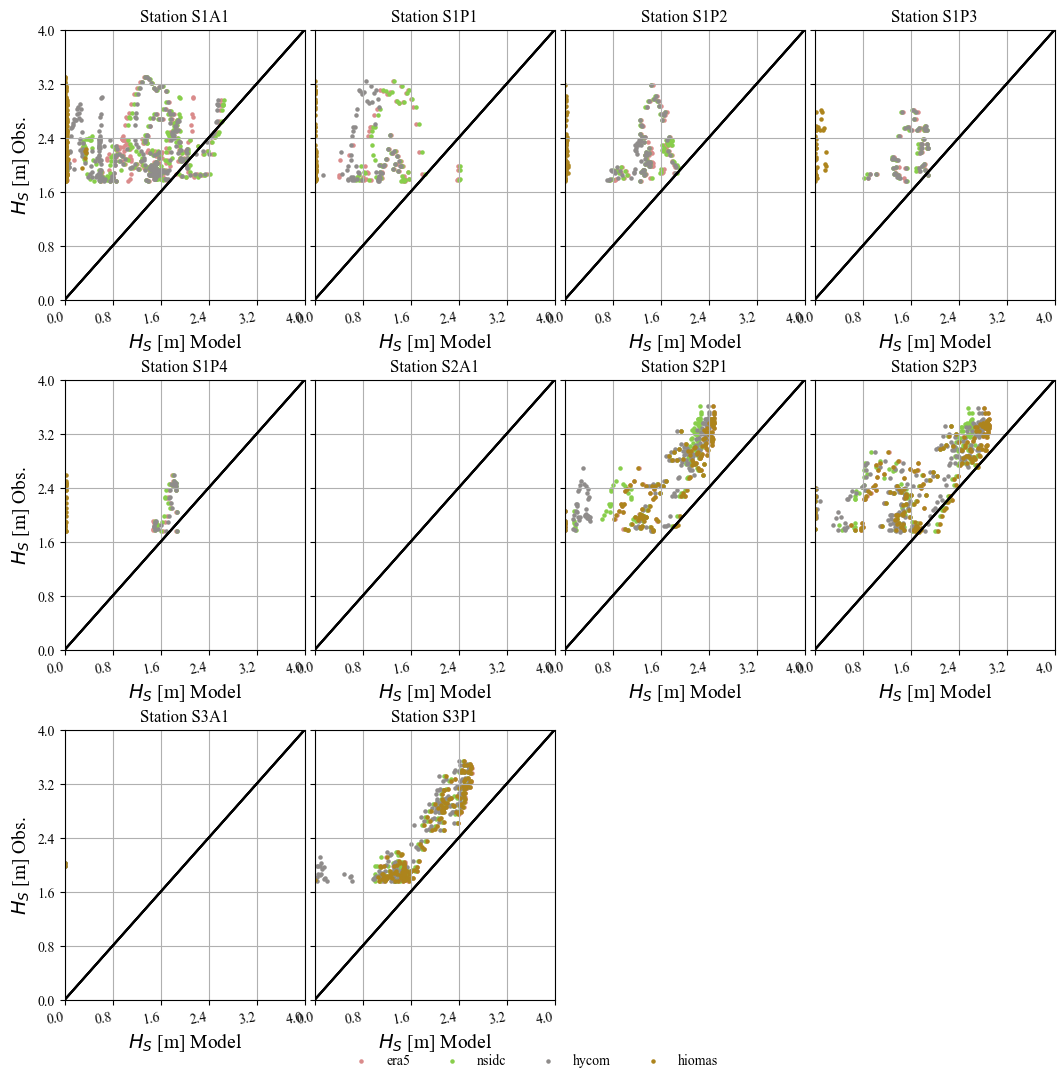

In [8]:
plt.rcParams["font.family"] = "Times New Roman"
colors = ['#1e74ae','#da8b8b','#88ce4b','#8f8c8b',
          '#ad841c','#994F00','#40B0A6','#D41159']
width =1.33
directories = ['era5','nsidc','hycom','hiomas']
peakstart,peakend = pd.to_datetime('20191115'),pd.to_datetime('20191125')
fig = plt.figure(figsize=(10,10))
ax = [plt.axes([0,0.7,0.24,.27]),plt.axes([0.25,0.7,0.24,.27]),plt.axes([0.5,0.7,.24,.27]),plt.axes([0.75,0.7,.24,.27]),
     plt.axes([0,0.35,.24,.27]),plt.axes([0.25,0.35,.24,.27]),plt.axes([0.5,0.35,.24,.27]),plt.axes([0.75,0.35,.24,.27]),
     plt.axes([0,0,.24,.27]),plt.axes([0.25,0,.24,.27])]
r2,c2=0,0
# field data
count = 0
for j in files:
    # observation data
    file = xr.open_dataset(j, engine='netcdf4')
    dt = pd.to_datetime(file['time']-719529, unit='D')
    c2=1
    node = [n for n in nodes.keys() if j.name.split('.')[0]==n]
    for d in directories[:]:
        ncfile = nc4.Dataset(root / d / 'outputs' /'swan_HS.63.nc')
        start = '20191001 00:00'
        dt2 = pd.date_range(start=start,periods=int(len(ncfile['swan_HS'][:,0])),freq='60min')
        dt3 = pd.date_range(start=start,end=dt2[-1],freq='60min')
        hso = np.interp(dt3,dt,file['sigwaveheight'])
        hsm = np.interp(dt3,dt2,ncfile['swan_HS'][:,nodes[node[0]][0]])
        hsm[np.isnan(hso)]=np.nan
        idp = np.where(hso>1.75)[0]
        
        # model data 
        ax[count].scatter(hsm[idp],hso[idp],label=f"{d}",c=colors[c2],s=5)
        ax[count].plot([0,5],[0,5],'k')
        c2+=1
    
    ax[count].set_ylim([0,4]), ax[count].set_xlim([0,4])#[pd.to_datetime('2019-10-15 00:00'),pd.to_datetime('2019-12-10')])
    #ax[count].tick_params(axis='x', labelsize=8),ax[count].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d'))
    for label in ax[count].get_xticklabels(which='major'):
        label.set(rotation=10, horizontalalignment='right')
    ax[count].xaxis.set_major_locator(plt.MaxNLocator(5)),ax[count].yaxis.set_major_locator(plt.MaxNLocator(6))
    ax[count].set_title(f"Station {j.name.split('.')[0]}",fontsize=12)
    ax[count].grid(True)
    ax[count].set_xlabel(r'$ H_{S}$ [m] Model',fontsize=14)
    count+=1
# plot limits


for i in [1,2,3,5,6,7,9]:
    ax[i].set_yticklabels(['','','','','',''])#, ax2.set_xticks([])

ax[0].set_ylabel(r'$ H_{S}$ [m] Obs.',fontsize=14)
ax[4].set_ylabel(r'$ H_{S}$ [m] Obs.',fontsize=14)
ax[8].set_ylabel(r'$ H_{S}$ [m] Obs.',fontsize=14)
#fig.delaxes(ax[3][2])
ax[0].legend(loc='lower center', bbox_to_anchor=(1.95, -2.89),ncol=4,frameon=False,fontsize=10)

plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/hs_metric.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1),
plt.show()

#### Plot Mesh

IndexError: tuple index out of range

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



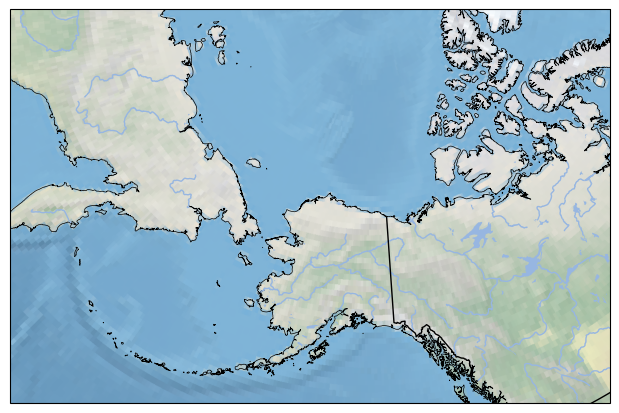

In [5]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 53,87
lon1,lon2 = -205, -110

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(6,5))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
#tiler = cart_img.GoogleTiles('terrain-background')

ax = plt.axes([0,0,1.,1.],projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)
levels = np.arange(0,8,0.25)

# Initialize data for map
gridvars = ncfile.variables
elems = gridvars['element'][:,:]-1
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")
#ax.add_image(tiler, 6)
ax.stock_img()

# plot mesh
hs = ncfile['swan_HS'][276,:]
triang = tri.Triangulation(x,y, triangles=elems)
if hs.mask.any():
    point_mask_indices = np.where(hs.mask)
    tri_mask = np.any(np.in1d(elems, point_mask_indices).reshape(-1, 3), axis=1)
    triang.set_mask(tri_mask)
#cf = plt.tricontourf(triang, hs,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)
cf = plt.triplot(triangles=triang,transform = ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")

#ax.set_title('MIROC6 Ice data',fontsize=12)
#plt.savefig('wave_map_miroc6.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

In [6]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 37.335063, 37.333473
lon1,lon2 = -76.436555, -76.431272

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(6,5))
proj = ccrs.PlateCarree()
#tiler = cart_img.GoogleTiles('terrain-background')

ax = plt.axes([0,0,1.,1.],projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)
levels = np.arange(0,8,0.25)

# Initialize data for map
gridvars = ncfile.variables
elems = gridvars['element'][:,:]-1
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")
#ax.add_image(tiler, 6)
ax.stock_img()

# plot mesh
hs = ncfile['swan_HS'][276,:]
triang = tri.Triangulation(x,y, triangles=elems)
if hs.mask.any():
    point_mask_indices = np.where(hs.mask)
    tri_mask = np.any(np.in1d(elems, point_mask_indices).reshape(-1, 3), axis=1)
    triang.set_mask(tri_mask)
cf = plt.tricontourf(triang, hs,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")

#ax.set_title('MIROC6 Ice data',fontsize=12)
#plt.savefig('wave_map_miroc6.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 600x500 with 1 Axes>

#### Plot wave spectra from swan

In [7]:
dset = wspec.read_swan(root / 'hycom' / 'outputs'/ '2DSpecOutABS')


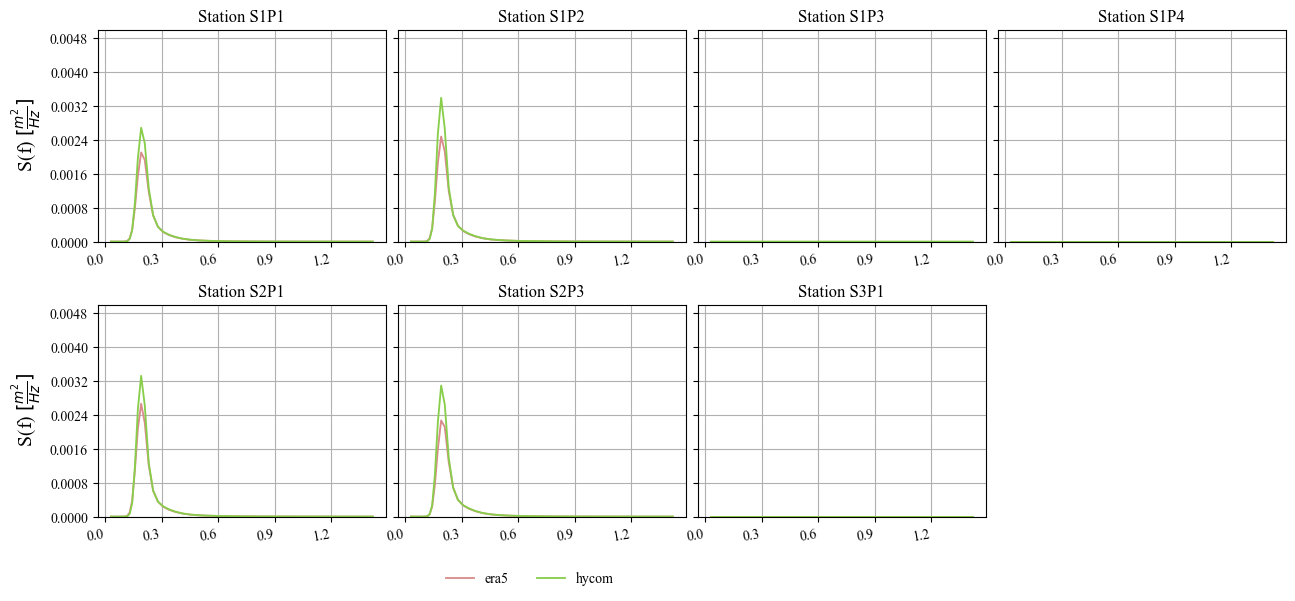

In [15]:
plt.rcParams["font.family"] = "Times New Roman"
colors = ['#1e74ae','#da8b8b','#88ce4b','#8f8c8b',
          '#ad841c','#994F00','#40B0A6','#D41159']
width =1.33
directories = ['era5','hycom']
fig = plt.figure(figsize=(12,5))
ax = [plt.axes([0,0.55,0.24,.425]),plt.axes([0.25,0.55,0.24,.425]),plt.axes([0.5,0.55,.24,.425]),plt.axes([0.75,0.55,.24,.425]),
     plt.axes([0,0,.24,.425]),plt.axes([0.25,0,.24,.425]),plt.axes([0.5,0,.24,.425])]
count = 0
for j in files:
    if 'A' in j.name.split('.')[0]:
        pass
    else:
        time,site,direction = 3300,count,0
        c2=1
        for d in directories:
            dset = wspec.read_swan(root / d / 'outputs'/ '2DSpecOutABS')
            #for f in range(0,len(dset['freq'])):

            ax[count].plot(dset['freq'],dset['efth'][time,site,:,direction],label=f"{d}",color=colors[c2],linewidth=width)
            #     else:
            #        ax[count].plot(dset['time'],dset['efth'][time,site,f,direction],color=colors[c2],linewidth=width)
            c2+=1
        ax[count].set_ylim([-0.00001,0.005]), 
        #ax[count].set_xlim([pd.to_datetime('2019-10-15 00:00'),pd.to_datetime('2019-12-10')])
        #ax[count].tick_params(axis='x', labelsize=8),ax[count].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d'))
        
        for label in ax[count].get_xticklabels(which='major'):
            label.set(rotation=10, horizontalalignment='right')
        ax[count].xaxis.set_major_locator(plt.MaxNLocator(6)),ax[count].yaxis.set_major_locator(plt.MaxNLocator(7))
        ax[count].set_title(f"Station {j.name.split('.')[0]}",fontsize=12)
        ax[count].grid(True)
        count+=1
    
for i in [1,2,3,5,6]:
    ax[i].set_yticklabels(['','','','','',''])#, ax2.set_xticks([])

ax[0].set_ylabel(r' S(f) $[\frac{m^{2}}{Hz}]$',fontsize=14),ax[4].set_ylabel(r' S(f) $[\frac{m^{2}}{Hz}]$',fontsize=14)
ax[0].ticklabel_format(axis='y',style='sci',useMathText=None),ax[4].ticklabel_format(axis='y',style='sci',useMathText=None)
#fig.delaxes(ax[3][2])
ax[0].legend(loc='lower center', bbox_to_anchor=(1.5, -1.675),ncol=4,frameon=False,fontsize=10)

#plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/hs_validation.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1),
plt.show()

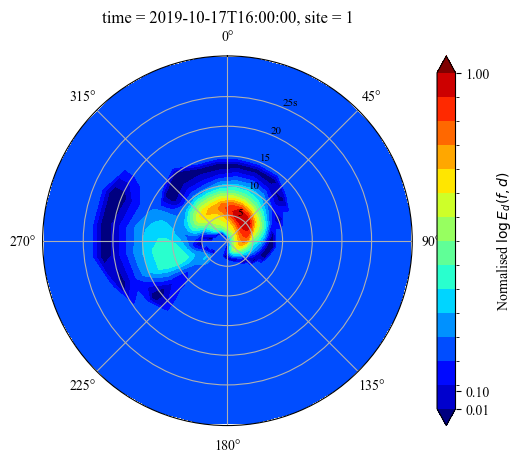

In [24]:

ds = dset.isel(site=0,time=1200)
ds1 = ds.where(ds>0, 1e-5) # Avoid infinity values

ds1 = np.log10(ds1)

ds1.spec.plot(as_period=True,
              logradius=False,
              cbar_kwargs={"label": "Normalised $\log{E_{d}(f,d)}$"},
              vmin=0.05,levels=15,
              extend="both",
              cmap=mpl.cm.get_cmap('jet'));directories

#### Plot wave and ice contours

In [112]:
def fmt(x):
    s = f"{x:.1f}"
    s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
def omitcontours(cf):
    for level in cf.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!
            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
            if diameter<2: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(
    return

In [34]:
dt2[1100]

Timestamp('2019-11-15 20:00:00', freq='60T')

IndexError: index exceeds dimension bounds

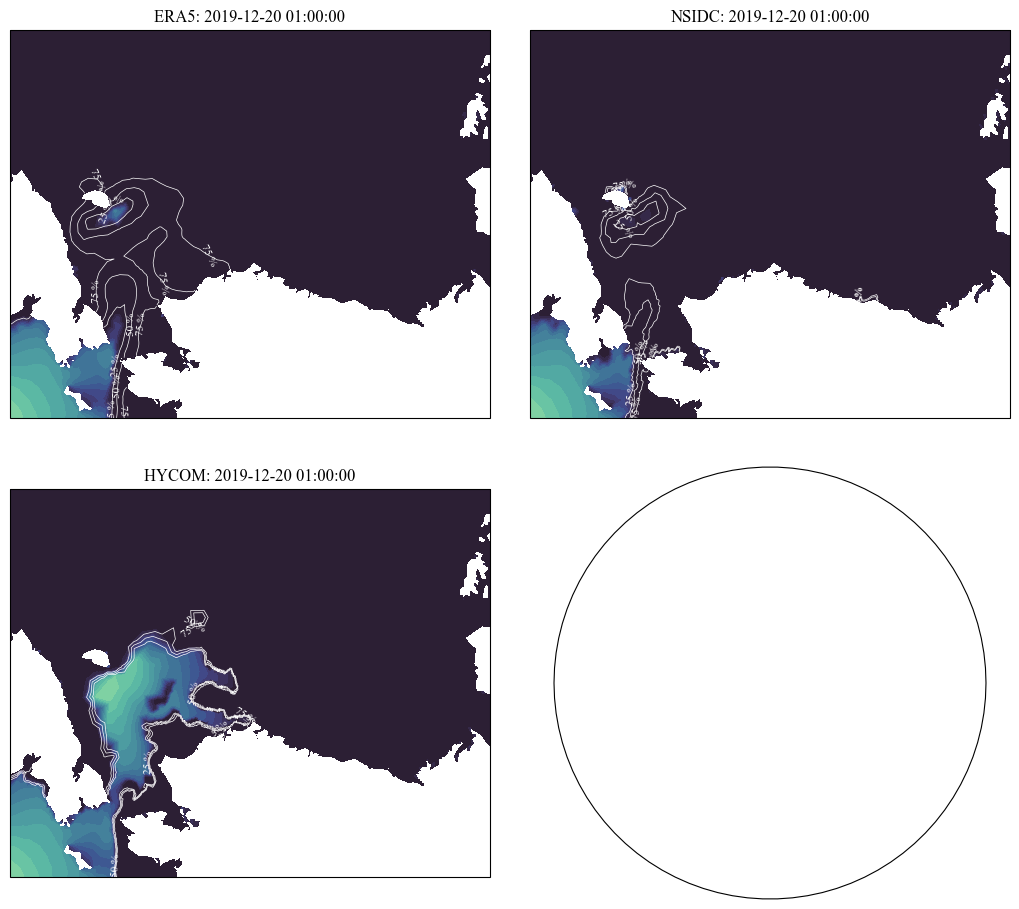

In [20]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 65,80
lon1,lon2 = -180, -130
start = '20191001 00:00'
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
wl = []
d = 'era5'
proj = ccrs.NorthPolarStereo(central_longitude=-145)
begin,hours=0,len(dt2)
cmap = cmocean.cm.deep_r
directories = {'era5':'ERA5','nsidc':'NSIDC','hycom':'HYCOM','hiomas':'HIOMAS'}
for i in np.arange(begin,hours,12):
    file_number = '%05d'%i
    fig = plt.figure(figsize=(10,9))    
    ax = [plt.axes([0,0.51,.48,.48],projection=proj),plt.axes([0.52,0.51,.48,.48],projection=proj),
         plt.axes([0,0,.48,.48],projection=proj),plt.axes([0.52,0,.48,.48],projection=proj)]
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    levels = np.arange(0,5,0.25)
    count=0
    for d in directories.keys():
        ncfile = nc4.Dataset(root / d / 'outputs' /'swan_HS.63.nc')
        Z = ncfile['swan_HS'][i,:]
        if Z.mask.any():
            point_mask_indices = np.where(Z.mask)
            tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
            triang.set_mask(tri_mask)
        levels = np.arange(0,5,0.25)
        cf = ax[count].tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)
        levels = np.arange(0,100,25)
        ncfile = nc4.Dataset(root / d / 'outputs' /'fort.93.nc')
        Z = ncfile['iceaf'][i,:]*100
        cf1 = ax[count].tricontour(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',colors = 'w', linewidths = 0.5)
        omitcontours(cf1)
        ax[count].clabel(cf1, inline=True, fontsize=8,fmt=fmt)
        ax[count].set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
        ax[count].set_title(f'{directories[d]}: {dt2[i]}')
        count+=1
    cbar_ax = fig.add_axes([0.125,-0.1,0.8,0.03])
    cbar = fig.colorbar(cf,cax = cbar_ax, orientation='horizontal')
    cbar.set_label(label = 'Significant Wave Height [meters]',fontsize = '12')
    plt.savefig('WL{}.png'.format(file_number),bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
    plt.close()

path = pl.Path('/Users/tmiesse/work/libraries/adcirc-unswan/outputs')
wl = list(path.glob('WL*'))
wl.sort()    
writer = imageio.get_writer('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/ice_waves.mp4', fps=10)
for im in wl:
    writer.append_data(imageio.imread(im))
writer.close()
for f in glob.glob('WL*'):
    os.remove(f)

In [21]:
path = pl.Path('/Users/tmiesse/work/libraries/adcirc-unswan/outputs')
wl = list(path.glob('WL*'))
wl.sort()    
writer = imageio.get_writer('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/ice_waves.mp4', fps=10)
for im in wl:
    writer.append_data(imageio.imread(im))
writer.close()
for f in glob.glob('WL*'):
    os.remove(f)

[libx264 @ 0x7ff0a9809400] frame MB size (383x391) > level limit (139264)


#### Plot Sea Ice extents for all products

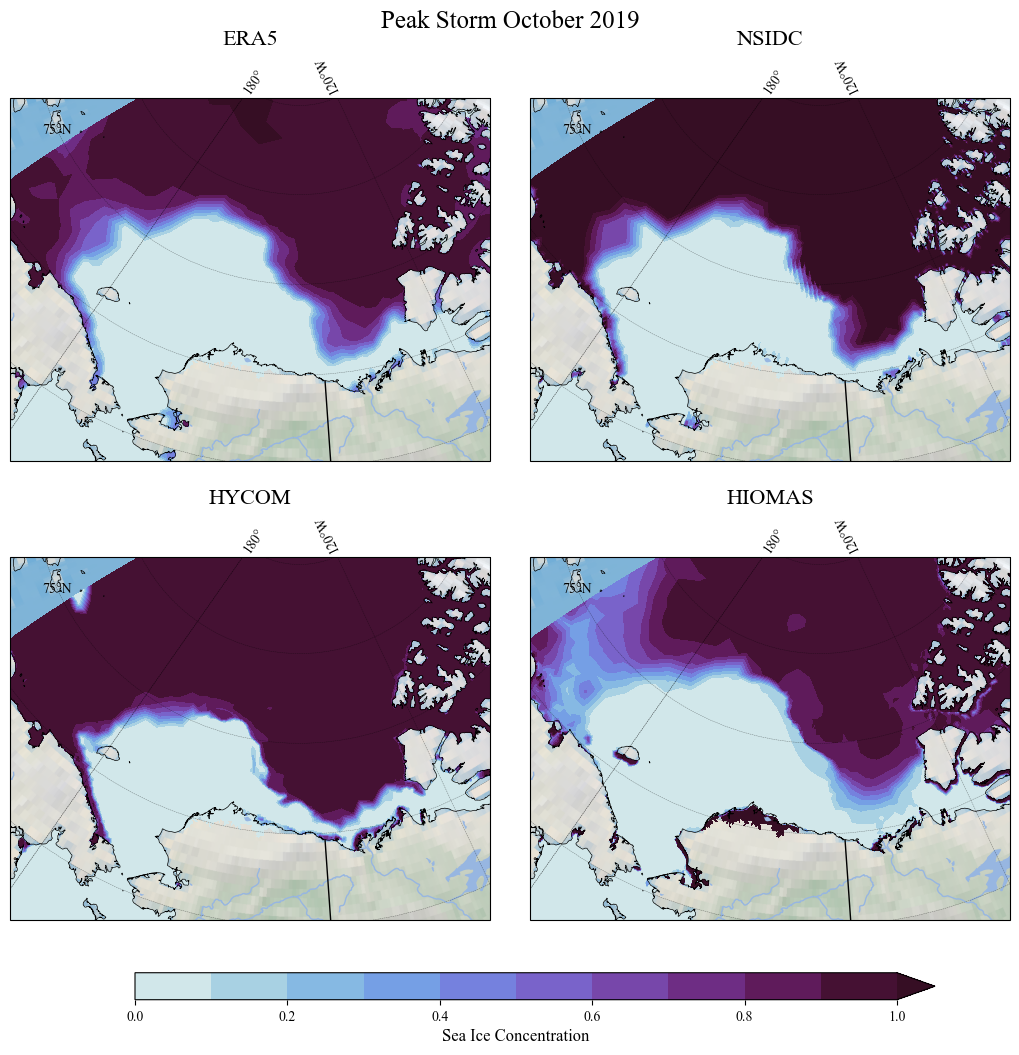

In [84]:
start,end = pd.to_datetime('20191031 18:00:00'),pd.to_datetime('20191031 19:00:00')

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 65,84
lon1,lon2 = -185, -120

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(10,9))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = [plt.axes([0,0.51,.48,.48],projection=proj),plt.axes([0.52,0.51,.48,.48],projection=proj),
     plt.axes([0,0,.48,.48],projection=proj),plt.axes([0.52,0,.48,.48],projection=proj)]

cmap = cmocean.cm.dense
fig.tight_layout(pad=0.75)
levels = np.arange(-0.0,1.1,0.1)
directories = {'era5':'ERA5','nsidc':'NSIDC','hycom':'HYCOM','hiomas':'HIOMAS'}
count = 0
i = 900
for d in directories.keys():
    ncfile = nc4.Dataset(root / d / 'outputs' /'fort.93.nc')
    dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['iceaf'][:,0])),freq='60min')
    idt = np.where((start<=dt2)&(dt2<end))[0]
    x,y = ncfile.variables['x'][:].data,ncfile.variables['y'][:].data
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    Z = ncfile['iceaf'][idt,:][0]
    if 'nsidc'==d:
        Z[Z>0.83]=1
    if Z.mask.any():
        point_mask_indices = np.where(Z.mask)
        tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
        triang.set_mask(tri_mask)
    cf = ax[count].tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels,extend ='max',cmap = cmap)

    ax[count].set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    ax[count].coastlines(resolution='10m',linewidth=0.5)
    ax[count].add_feature(cart.feature.LAKES)
    ax[count].add_feature(cart.feature.RIVERS,linestyle="-")
    ax[count].add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
    gl = ax[count].gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
    ax[count].set_title(directories[d],fontsize=16)
    ax[count].stock_img()
    count+=1
plt.suptitle('Peak Storm October 2019',fontsize =18,y=1.05)
ax[0].clabel(cf1, inline=True, fontsize=8,fmt=fmt)
cbar_ax = fig.add_axes([0.125,-0.05,0.8,0.03])
cbar = fig.colorbar(cf,cax = cbar_ax, orientation='horizontal')
cbar.set_label(label = 'Sea Ice Concentration',fontsize =12)   
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/oct_ice.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

### Plot wave direction and height for peak storm

In [25]:
lat1,lat2 = 50,87
lon1,lon2 = -225, -85
space = 0.25
x,y = ncfile.variables['x'][:].data,ncfile.variables['y'][:].data

xgrid,ygrid = np.meshgrid(np.arange(lon1,lon2,space),np.arange(lat1,lat2,space))

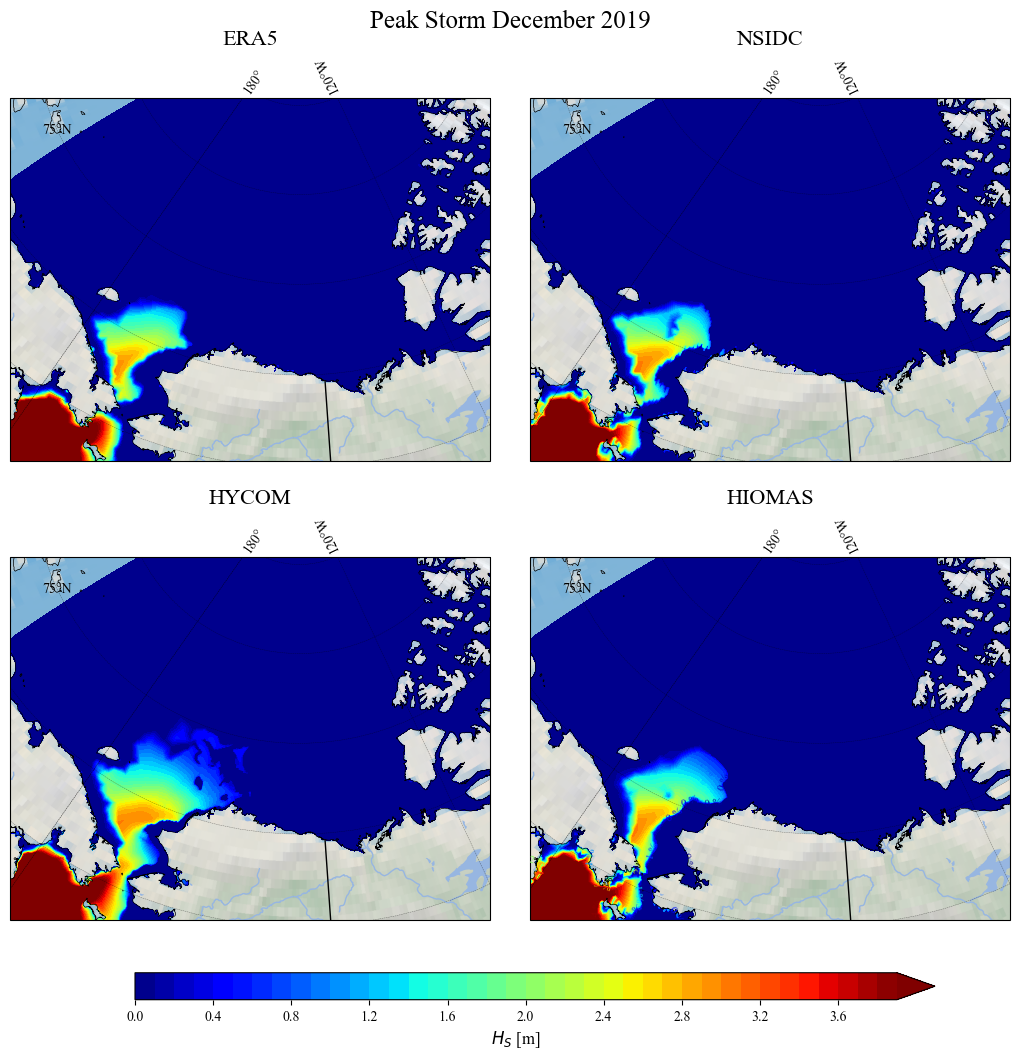

In [26]:
start,end = pd.to_datetime('20191207 00:00:00'),pd.to_datetime('20191207 01:00:00')

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 65,84
lon1,lon2 = -185, -120

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(10,9))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = [plt.axes([0,0.51,.48,.48],projection=proj),plt.axes([0.52,0.51,.48,.48],projection=proj),
     plt.axes([0,0,.48,.48],projection=proj),plt.axes([0.52,0,.48,.48],projection=proj)]

cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)
levels = np.arange(-0.0,4,0.1)
directories = {'era5':'ERA5','nsidc':'NSIDC','hycom':'HYCOM','hiomas':'HIOMAS'}
count = 0
i = 900
for d in directories.keys():
    ncfile = nc4.Dataset(root / d / 'outputs' /'swan_HS.63.nc')
    dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['swan_HS'][:,0])),freq='60min')
    idt = np.where((start<=dt2)&(dt2<end))[0]
    
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    Z = ncfile['swan_HS'][idt,:][0]
    if Z.mask.any():
        point_mask_indices = np.where(Z.mask)
        tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
        triang.set_mask(tri_mask)
    cf = ax[count].tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels,extend ='max',cmap = cmap)
    ax[count].set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    ax[count].coastlines(resolution='10m',linewidth=0.5)
    ax[count].add_feature(cart.feature.LAKES)
    ax[count].add_feature(cart.feature.RIVERS,linestyle="-")
    ax[count].add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
    gl = ax[count].gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
    ax[count].set_title(directories[d],fontsize=16)
    ax[count].stock_img()
    count+=1
plt.suptitle('Peak Storm December 2019',fontsize =18,y=1.05)
ax[0].clabel(cf, inline=False, fontsize=8,fmt=fmt)
cbar_ax = fig.add_axes([0.125,-0.05,0.8,0.03])
cbar = fig.colorbar(cf,cax = cbar_ax, orientation='horizontal')
cbar.set_label(label = r'$H_{S}$ [m]',fontsize =12)   
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/dec_wave.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

### Plot wave height difference to NSIDC for peak storm

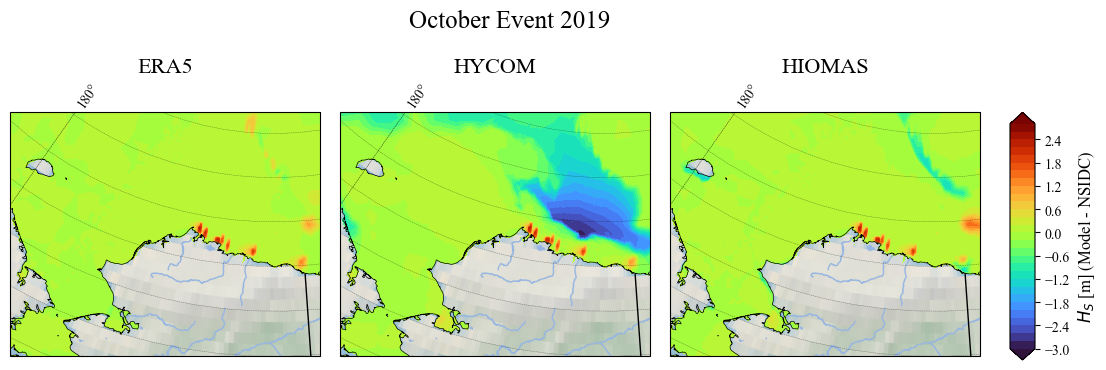

In [50]:
start,end = pd.to_datetime('20191018 03:00:00'),pd.to_datetime('20191018 04:00:00')
#start,end = pd.to_datetime('20191112 11:00:00'),pd.to_datetime('20191112 12:00:00')
#start,end = pd.to_datetime('20191127 20:00:00'),pd.to_datetime('20191127 21:00:00')
#start,end = pd.to_datetime('20191203 16:00:00'),pd.to_datetime('20191203 17:00:00')
idt = np.where((start<=dt2)&(dt2<end))[0]

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 66,75
lon1,lon2 = -175, -140

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(10,9))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = [plt.axes([0,0.,0.31,.9],projection=proj),plt.axes([0.33,0.,.31,.9],projection=proj),
     plt.axes([0.66,0,.31,.9],projection=proj)]#,plt.axes([0.52,0,.48,.48],projection=proj)]
#cmap = cmocean.cm.dense
cmap = mpl.cm.get_cmap('turbo')
fig.tight_layout(pad=0.75)
levels = np.arange(-3.0,3,0.2)
directories = {'nsidc':'NSIDC','era5':'ERA5','hycom':'HYCOM','hiomas':'HIOMAS'}
count = 0
i = 900
nsidc = nc4.Dataset(root / 'nsidc' / 'outputs' /'swan_HS.63.nc')
for d in list(directories.keys())[1:]:
    ncfile = nc4.Dataset(root / d / 'outputs' /'swan_HS.63.nc')
    dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['swan_HS'][:,0])),freq='60min')
    idt = np.where((start<=dt2)&(dt2<end))[0]
    
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    Z = ncfile['swan_HS'][idt,:][0]
    diff = Z-nsidc['swan_HS'][idt,:][0]
    if diff.mask.any():
        point_mask_indices = np.where(diff.mask)
        tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
        triang.set_mask(tri_mask)
   
    cf = ax[count].tricontourf(triang, diff,transform = ccrs.PlateCarree(),levels=levels,cmap = cmap,extend ='both')
    if count<1:
        #cb = plt.colorbar(cf,cmap=cmap,fraction=0.025,pad=0.04) 
        #ax[count].clabel(cf, inline=True, fontsize=8,fmt=fmt)
        cbar_ax = fig.add_axes([1.,0.31,0.025,0.275])
        cbar = fig.colorbar(cf,cax = cbar_ax, orientation='vertical')
        cbar.set_label(label = r'$H_{S}$ [m] (Model - NSIDC)',fontsize =12)   
    ax[count].set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    ax[count].coastlines(resolution='10m',linewidth=0.5)
    ax[count].add_feature(cart.feature.LAKES)
    ax[count].add_feature(cart.feature.RIVERS,linestyle="-")
    ax[count].add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
    gl = ax[count].gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
    ax[count].set_title(directories[d],fontsize=16)
    ax[count].stock_img()
    count+=1
plt.suptitle('October Event 2019',fontsize =18,y=.70)


plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/oct_wave_diffv2.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

### Plot Ice Extents

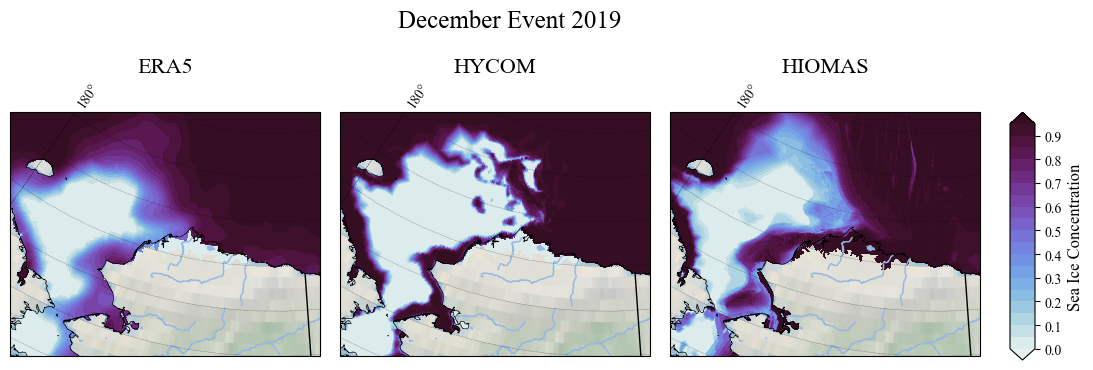

In [8]:
#start,end = pd.to_datetime('20191018 03:00:00'),pd.to_datetime('20191018 04:00:00')
#start,end = pd.to_datetime('20191112 11:00:00'),pd.to_datetime('20191112 12:00:00')
#start,end = pd.to_datetime('20191127 20:00:00'),pd.to_datetime('20191127 21:00:00')
start,end = pd.to_datetime('20191207 18:00:00'),pd.to_datetime('20191207 19:00:00')
idt = np.where((start<=dt2)&(dt2<end))[0]

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 66,75
lon1,lon2 = -175, -140

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(10,9))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = [plt.axes([0,0.,0.31,.9],projection=proj),plt.axes([0.33,0.,.31,.9],projection=proj),
     plt.axes([0.66,0,.31,.9],projection=proj)]#,plt.axes([0.52,0,.48,.48],projection=proj)]
#cmap = cmocean.cm.dense
cmap = cmocean.cm.dense
fig.tight_layout(pad=0.75)
levels = np.arange(-.0,1,0.05)
directories = {'nsidc':'NSIDC','era5':'ERA5','hycom':'HYCOM','hiomas':'HIOMAS'}
count = 0


for d in list(directories.keys())[1:]:
    ncfile = nc4.Dataset(root / d / 'outputs' /'fort.93.nc')
    dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['iceaf'][:,0])),freq='60min')
    idt = np.where((start<=dt2)&(dt2<end))[0]
    
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    Z = ncfile['iceaf'][idt,:][0]
    #diff = Z-nsidc['swan_HS'][idt,:][0]
    if Z.mask.any():
        point_mask_indices = np.where(diff.mask)
        tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
        triang.set_mask(tri_mask)
   
    cf = ax[count].tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels,cmap = cmap,extend ='both')
    if count<1:
        #cb = plt.colorbar(cf,cmap=cmap,fraction=0.025,pad=0.04) 
        #ax[count].clabel(cf, inline=True, fontsize=8,fmt=fmt)
        cbar_ax = fig.add_axes([1.,0.31,0.025,0.275])
        cbar = fig.colorbar(cf,cax = cbar_ax, orientation='vertical')
        cbar.set_label(label = r'Sea Ice Concentration',fontsize =12)   
    ax[count].set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    ax[count].coastlines(resolution='10m',linewidth=0.5)
    ax[count].add_feature(cart.feature.LAKES)
    ax[count].add_feature(cart.feature.RIVERS,linestyle="-")
    ax[count].add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
    gl = ax[count].gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
    ax[count].set_title(directories[d],fontsize=16)
    ax[count].stock_img()
    count+=1
plt.suptitle('December Event 2019',fontsize =18,y=.70)


plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/dec_ice.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

#### Extract Ice Extent change for each month

In [5]:
start,end = pd.to_datetime('20191021 00:00:00'),pd.to_datetime('20191021 01:00:00')
lat1,lat2 = 68,87
lon1,lon2 = -225, -85
ncfile = nc4.Dataset(root / 'nsidc' / 'outputs' /'fort.93.nc')
dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['iceaf'][:,0])),freq='60min')
idt = np.where((start<=dt2)&(dt2<end))[0]
limits = [0.999,1]
z = ncfile['iceaf'][idt,:]
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
ids = np.where((-200<x)&(x<=-127)&(y>lat1))

In [6]:
def fmt(x):
    s = f"{x:.1f}"
    s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
def omitcontours(cf):
    for level in cf.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!
            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
            if diameter<2: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(
    return

In [ ]:
var = 'iceaf'
levels = [0, 0.5, 0.1]
conType = 'polygon'
epsgIn = 4326
epsgOut = 4326  # output in latitude and longitude, based on downscaling DEM
vUnitIn = 'm' ## Default 'm'
vUnitOut = 'm' ## Default 'ft'
subDomain = None  ## Default None
exportMesh = False  ## Default False
meshName = None  ## Default None
dzFile = None  ## Default None
zeroDif = -20  ## Default -20
outpath = '/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/ice_contours/from_model/nsidc/nisdc_oct.shp'
gdf = nc2shp(str(root / 'nsidc' / 'outputs' /'fort.93.nc'), var, levels, conType, outpath, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
           subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif)

Start exporting adcirc to shape


 73%|█████████████████████████████████████████████▏                | 1508/2069 [52:09<25:25,  2.72s/it]

In [251]:

z[0][np.where(y<lat1)[0]]=0
z[0][np.where(x>-127)[0]]=0
levels = np.arange(0.8,1.0,0.1)
#### extract ice contours
#idx = np.where((limits[0]<z.data[0])&(z.data[0]<=limits[1])&(lat1<y))[0]
triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
cf = plt.tricontourf(triang, z[0],levels=levels,extend='max')
omitcontours(cf)

plt.close()

In [252]:
contour = []
for c in cf.collections:
    for v in c.get_paths():
        contour.append(LineString([Point([v.vertices[i,0],v.vertices[i,1]]) for i in range(len(v.vertices[:,0]))]))# \
                                #if (v.vertices[i,1]>lat1)&(-200<v.vertices[i,0])&(v.vertices[i,0]<-127)]))

In [253]:
gdf = gpd.GeoDataFrame({'id':'c1','geo':contour},geometry='geo',crs='epsg:4326')
gdf.to_file('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/ice_contours/nov/nsidc/seaice_ext.shp')

In [7]:
ncfile = nc4.Dataset(root / 'nsidc' / 'outputs' /'fort.73.nc')
start = '20191001 00:00'
dt2 = pd.date_range(start=start,periods=int(len(ncfile.variables['pressure'][:,0])),freq='60min')
wind = nc4.Dataset(root / 'nsidc' / 'outputs' /'fort.74.nc')
bbox = Polygon([(-230,50),(-230,90),(-80,90),(-80,50)])
pressure = ncfile['pressure']

In [8]:
limits = [9.6,10.]
step = 1
track = []
pt = 0
spoint = None
for t in range(100,len(dt2)):
    idp = np.where((limits[0]<=pressure[t,:])&(pressure[t,:]<limits[1]))[0]
    idw = np.where((wind['windx'][t,idp]<5)&(wind['windy'][t,idp]<5))
    if spoint==None:
        spoint = np.where((limits[0]<=pressure[t,idw])&(pressure[t,idw]<10))[0]
        c=0.1
        while len(spoint)==0:
            spoint = np.where((limits[0]<=pressure[t,idw])&(pressure[t,idw]<10+c))[0]
            c+=0.05
        bbox = Polygon([(x[spoint]-step,y[spoint]-step),(x[spoint]-step,y[spoint]+step),
                        (x[spoint]+step,y[spoint]+step),(x[spoint]+step,y[spoint]-step)])
    elif pt!=spoint:   
        node= np.where((shapely.vectorized.contains(bbox, x[idw], y[idw])==True))[0]
        pt = np.where(np.min(pressure[t,node]))[0]
        bbox = Polygon([(x[pt][0]-step,y[pt][0]-step),(x[node][0]-step,y[pt][0]+step),
                    (x[pt][0]+step,y[pt][0]+step),(x[pt][0]+step,y[pt][0]-step)])
        pts = Point(x[pt],y[pt])
        track.append(pts)


IndexError: Index cannot be multidimensional

In [14]:
ncfile = nc4.Dataset(root / 'era5' / 'outputs' /'fort.73.nc')
start = '20191001 00:00'
dt2 = pd.date_range(start=start,periods=int(len(ncfile.variables['pressure'][:,0])),freq='60min')
wind = nc4.Dataset(root / 'nsidc' / 'outputs' /'fort.74.nc')
pressure = ncfile['pressure']

In [15]:
lat1,lat2 = 50,87
lon1,lon2 = -225, -85
spacex,spacey = 2,1
x,y = ncfile.variables['x'][:].data,ncfile.variables['y'][:].data

xgrid,ygrid = np.meshgrid(np.arange(lon1,lon2,spacex),np.arange(lat1,lat2,spacey))
shpfile = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/country_shapefiles/World_Countries_(Generalized)/arctic_dissolve.shp')
mask= np.where((shapely.vectorized.contains(shpfile.geometry[0], xgrid, ygrid)==True))#[0]

In [45]:
dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['windx'][:,0])),freq='60min')
start,end = pd.to_datetime('20191018 03:00:00'),pd.to_datetime('20191018 04:00:00')
start,end = pd.to_datetime('20191112 11:00:00'),pd.to_datetime('20191112 12:00:00')
start,end = pd.to_datetime('20191127 20:00:00'),pd.to_datetime('20191127 21:00:00')
start,end = pd.to_datetime('20191203 16:00:00'),pd.to_datetime('20191203 17:00:00')
idt = np.where((start<=dt2)&(dt2<end))[0]
title = 'December 2nd Storm 2019'

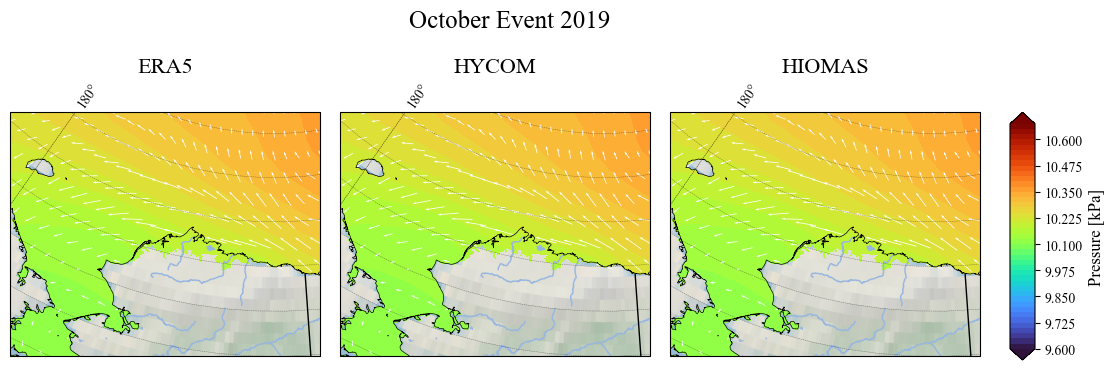

In [46]:
#start,end = pd.to_datetime('20191207 00:00:00'),pd.to_datetime('20191207 01:00:00')

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 66,75
lon1,lon2 = -175, -140

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(10,9))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = [plt.axes([0,0.,0.31,.9],projection=proj),plt.axes([0.33,0.,.31,.9],projection=proj),
     plt.axes([0.66,0,.31,.9],projection=proj)]#,plt.axes([0.52,0,.48,.48],projection=proj)]
#cmap = cmocean.cm.dense
cmap = mpl.cm.get_cmap('turbo')
fig.tight_layout(pad=0.75)
levels = np.arange(9.6,10.7,0.025)
directories = {'nsidc':'NSIDC','era5':'ERA5','hycom':'HYCOM','hiomas':'HIOMAS'}
count = 0
i = 900

for d in list(directories.keys())[1:]:
    ncfile = nc4.Dataset(root / d / 'outputs' /'fort.73.nc')
    dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['pressure'][:,0])),freq='60min')
    idt = np.where((start<=dt2)&(dt2<end))[0]
    
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    Z = ncfile['pressure'][idt,:][0]
    if Z.mask.any():
        point_mask_indices = np.where(Z.mask)
        tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
        triang.set_mask(tri_mask)
   
    cf = ax[count].tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels,cmap = cmap,extend ='both')
    if count<1:
        #cb = plt.colorbar(cf,cmap=cmap,fraction=0.025,pad=0.04) 
        #ax[count].clabel(cf, inline=True, fontsize=8,fmt=fmt)
        cbar_ax = fig.add_axes([1.,0.31,0.025,0.275])
        cbar = fig.colorbar(cf,cax = cbar_ax, orientation='vertical')
        cbar.set_label(label = r'Pressure [kPa]',fontsize =12)
    ncfile = nc4.Dataset(root / d / 'outputs' /'fort.74.nc')
    ugrid = scipy.interpolate.griddata((x,y),ncfile['windx'][idt,:][0],(xgrid,ygrid),method='nearest')
    vgrid = scipy.interpolate.griddata((x,y),ncfile['windy'][idt,:][0],(xgrid,ygrid),method='nearest')
    ugrid[mask],vgrid[mask]=np.nan,np.nan
    q = ax[count].quiver(xgrid,ygrid,ugrid,vgrid, pivot='mid', scale = 200, color='w',transform = ccrs.PlateCarree(),linewidth=1,label='wind')

    ax[count].set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    ax[count].coastlines(resolution='10m',linewidth=0.5)
    ax[count].add_feature(cart.feature.LAKES)
    ax[count].add_feature(cart.feature.RIVERS,linestyle="-")
    ax[count].add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
    gl = ax[count].gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
    ax[count].set_title(directories[d],fontsize=16)
    ax[count].stock_img()
    count+=1
plt.suptitle('October Event 2019',fontsize =18,y=.70)


plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/oct_atmo.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

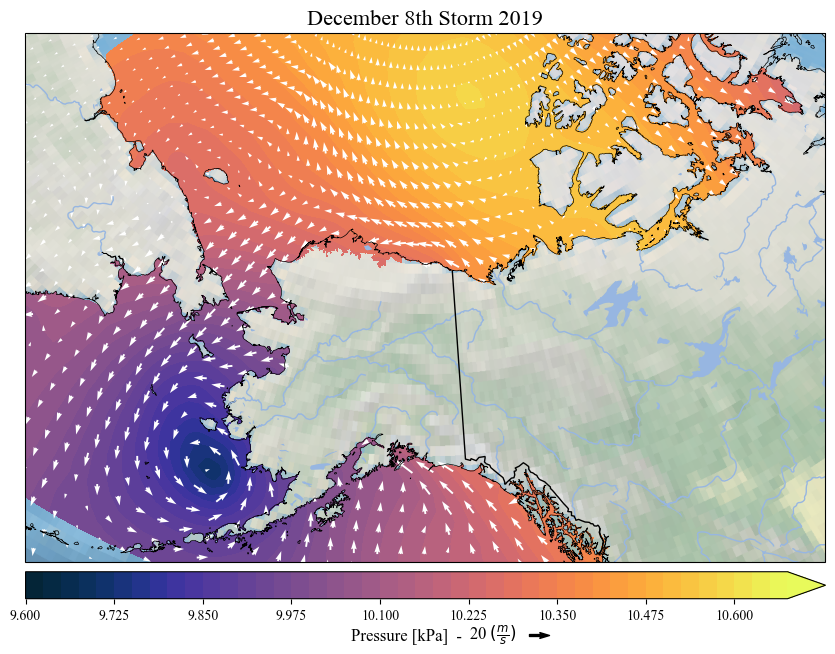

In [118]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 55,80
lon1,lon2 = -180, -110
start = '20191001 00:00'
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
proj = ccrs.NorthPolarStereo(central_longitude=-145)
begin,hours=1,len(dt2)
cmap = cmocean.cm.thermal

fig = plt.figure(figsize=(10,9))
ax = plt.axes([0,0,.8,.8],projection=proj)
levels = np.arange(9.6,10.7,0.025)

Z = ncfile['pressure'][idt,:]
triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
if Z.mask.any():
    point_mask_indices = np.where(Z.mask)
    tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
    triang.set_mask(tri_mask)
cf = ax.tricontourf(triang, Z[0],transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)

ugrid = scipy.interpolate.griddata((x,y),wind['windx'][idt,:][0],(xgrid,ygrid),method='nearest')
vgrid = scipy.interpolate.griddata((x,y),wind['windy'][idt,:][0],(xgrid,ygrid),method='nearest')
ugrid[mask],vgrid[mask]=np.nan,np.nan
q = ax.quiver(xgrid,ygrid,ugrid,vgrid, pivot='mid', scale = 800, color='w',transform = ccrs.PlateCarree(),linewidth=1,label='wind')

ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS,linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
ax.stock_img()
ax.set_title(title,fontsize=16)
ax.quiverkey(q,X=.63,Y=-0.138,U=20,label=r'20 $(\frac{m}{s})$ ',color='k',labelpos='W',transform = ccrs.PlateCarree(),fontproperties={'size':12})

cbar_ax = fig.add_axes([0.001,0.065,0.8,0.03])
cbar = fig.colorbar(cf,cax = cbar_ax, orientation='horizontal')
cbar.set_label(label = 'Pressure [kPa]  -',fontsize = '12')
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/dec_storm2.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [87]:
idt

array([1245])

In [6]:
ncfile = nc4.Dataset(root / 'nsidc' / 'outputs' /'fort.73.nc')
start = '20191001 00:00'
dt2 = pd.date_range(start=start,periods=int(len(ncfile.variables['pressure'][:,0])),freq='60min')
wind = nc4.Dataset(root / 'nsidc' / 'outputs' /'fort.74.nc')
pressure = ncfile['pressure']

In [7]:
dt2 = pd.date_range(start='20191001 01:00:00',periods=int(len(ncfile.variables['pressure'][:,0])),freq='60min')
start,end = pd.to_datetime('20191008 00:00:00'),pd.to_datetime('20191218 01:00:00')
idt = np.where((start<=dt2)&(dt2<end))[0]
title = 'Nov-Dec Storm 2019'

In [8]:
lat1,lat2 = 50,87
lon1,lon2 = -225, -85
spacex,spacey = 2,1
x,y = ncfile.variables['x'][:].data,ncfile.variables['y'][:].data

xgrid,ygrid = np.meshgrid(np.arange(lon1,lon2,spacex),np.arange(lat1,lat2,spacey))
shpfile = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/country_shapefiles/World_Countries_(Generalized)/arctic_dissolve.shp')
mask= np.where((shapely.vectorized.contains(shpfile.geometry[0], xgrid, ygrid)==True))#[0]

In [12]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 55,80
lon1,lon2 = -180, -110
start = '20191001 00:00'
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
wl = []
d = 'era5'
proj = ccrs.NorthPolarStereo(central_longitude=-145)
begin,hours=1,len(dt2)
cmap = cmocean.cm.thermal
directories = {'era5':'ERA5','nsidc':'NSIDC','hycom':'HYCOM','hiomas':'HIOMAS'}

for i in np.arange(idt[0],idt[-1],4):#np.arange(begin,hours,12):
    file_number = '%05d'%i
    fig = plt.figure(figsize=(10,9))
    ax = plt.axes([0,0,.8,.8],projection=proj)
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    levels = np.arange(9.6,10.7,0.025)
    count=0       
    Z = ncfile['pressure'][i,:]
    if Z.mask.any():
        point_mask_indices = np.where(Z.mask)
        tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
        triang.set_mask(tri_mask)
    cf = ax.tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)

    ugrid = scipy.interpolate.griddata((x,y),wind['windx'][i,:],(xgrid,ygrid),method='nearest')
    vgrid = scipy.interpolate.griddata((x,y),wind['windy'][i,:],(xgrid,ygrid),method='nearest')
    ugrid[mask]=np.nan
    vgrid[mask]=np.nan
    q = ax.quiver(xgrid,ygrid,ugrid,vgrid, pivot='mid', scale = 800, color='w',transform = ccrs.PlateCarree())

    ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

    ax.coastlines(resolution='10m',linewidth=0.5)
    ax.add_feature(cart.feature.LAKES)
    ax.add_feature(cart.feature.RIVERS,linestyle="-")
    ax.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
    ax.stock_img()
    title = f'{directories["nsidc"]}: {dt2[i]}'
    ax.set_title(title)
    title=None
    count+=1
    #wl.append('WL{}.png'.format(file_number))
    ax.quiverkey(q,X=.63,Y=-0.1415,U=20,label=r'20 $(\frac{m}{s})$ ',color='k',labelpos='W',transform = ccrs.PlateCarree(),fontproperties={'size':12})

    cbar_ax = fig.add_axes([0.001,0.065,0.8,0.03])
    cbar = fig.colorbar(cf,cax = cbar_ax, orientation='horizontal')
    cbar.set_label(label = 'Pressure [kPa]  -',fontsize = '12')
    plt.savefig('WL{}.png'.format(file_number),bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
    plt.close()


path = pl.Path('/Users/tmiesse/work/libraries/adcirc-unswan/outputs')
wl = list(path.glob('WL*'))
wl.sort()    
writer = imageio.get_writer('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/figures/storm.mp4', fps=10)
for im in wl:
    writer.append_data(imageio.imread(im))
writer.close()
for f in glob.glob('WL*'):
    os.remove(f)


[swscaler @ 0x7f9d0ba68000] Warning: data is not aligned! This can lead to a speed loss


In [3]:
path = pl.Path('/Users/tmiesse/Downloads/GIF_images')
wl = list(path.glob('*'))
wl.sort()    
writer = imageio.get_writer('/Users/tmiesse/Downloads/video.mp4', fps=10)
for im in wl:
    writer.append_data(imageio.imread(im))
writer.close()
for f in list(path.glob('*')):
    os.remove(f)

ValueError: All images in a movie should have same size